# Step 1: Data Exploration and Preparation

<H3>1.1. Load the Data and Basic Checks</H3>

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv("retail_sales_mock_data.csv")

# preview the data
print(df.shape)
print(df.dtypes)
df.head()

(48, 4)
Date            object
SalesAmount      int64
Promotion        int64
HolidayMonth     int64
dtype: object


,Date,SalesAmount,Promotion,HolidayMonth
0,2020-01-01,12248,0,0
1,2020-02-01,13011,0,0
2,2020-03-01,12722,0,0
3,2020-04-01,14030,1,0
4,2020-05-01,7783,0,0


<H3>1.2. Convert 'Date' to datetime and set as index</H3>

In [3]:
# convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set date as index
df.set_index('Date', inplace=True)

# Confirm
df.head()

,SalesAmount,Promotion,HolidayMonth
Date,,,
2020-01-01,12248,0,0
2020-02-01,13011,0,0
2020-03-01,12722,0,0
2020-04-01,14030,1,0
2020-05-01,7783,0,0


In [4]:
df.shape

(48, 3)

<H3>1.3. Plot the Time Series</H3>
This will help you see overall trends and seasonality:

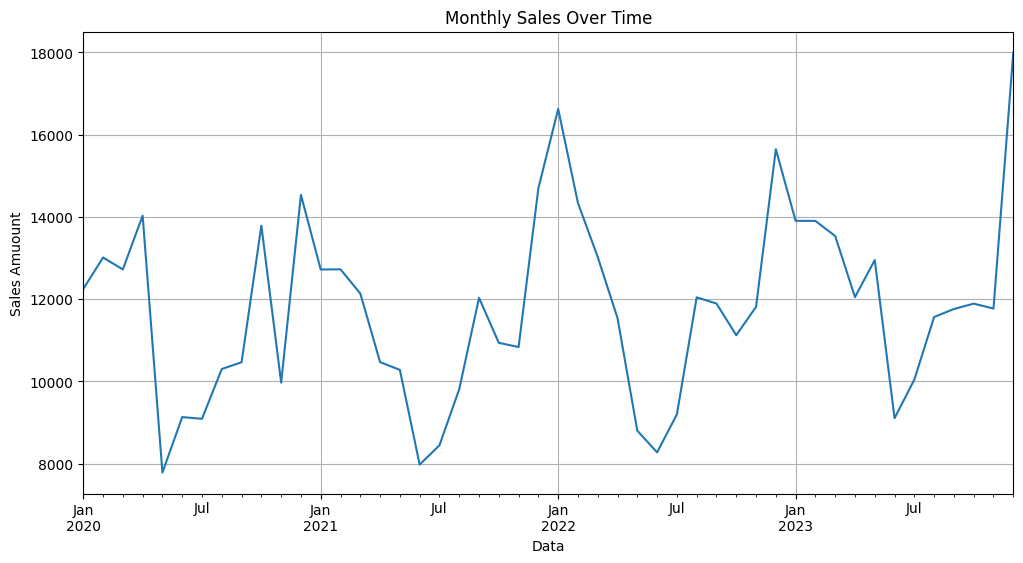

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
df['SalesAmount'].plot()
plt.title('Monthly Sales Over Time')
plt.xlabel('Data')
plt.ylabel('Sales Amuount')
plt.grid(True)
plt.show()

<H3>1.4. Decompose the Time Series</H3>
Break it into trend, seasonality, and residuals:

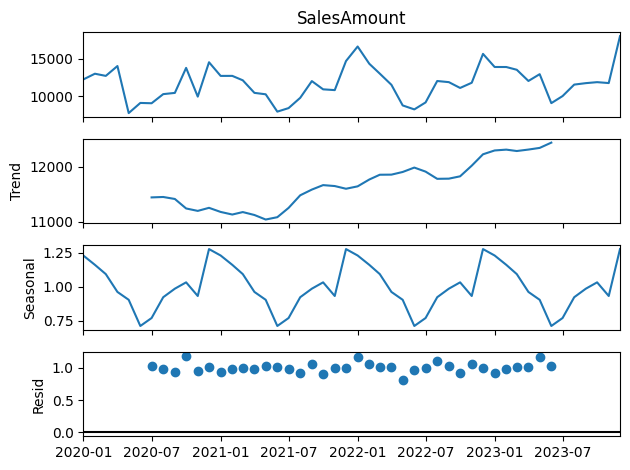

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['SalesAmount'], model= 'multiplicative', period=12)
result.plot()
plt.show()

<H3>1.5. Check for Stationarity (ADF Test)</H3>
Checks if time series has a stable mean/variance over time.

In [7]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['SalesAmount'])

print(f'ADF Statistics {adf_result[0]}')
print(f'P Value {adf_result[1]}')

for key, value in adf_result[4].items():
    print('Critical Value (%s): %3.f' % (key, value))

ADF Statistics -4.514183597733958
P Value 0.0001853558643026136
Critical Value (1%):  -4
Critical Value (5%):  -3
Critical Value (10%):  -3


<H3>1.6. Visualize Autocorrelation (ACF/PACF)</H3>
We’ll use this later for SARIMA tuning

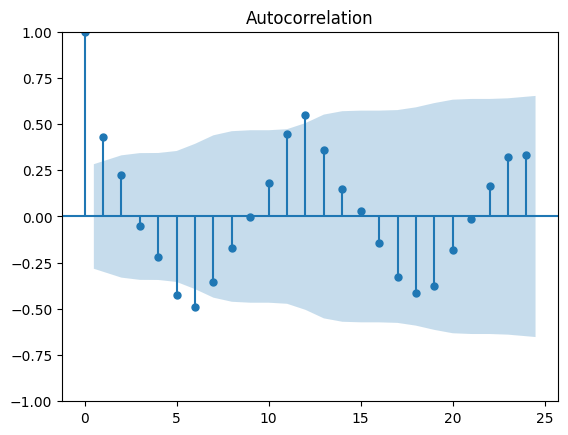

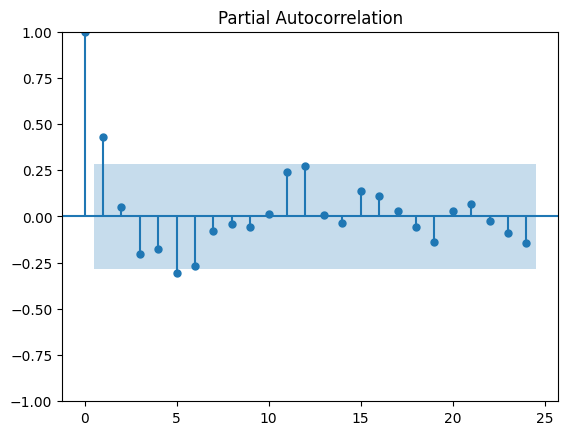

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['SalesAmount'], lags=24)
plt.show()

plot_pacf(df['SalesAmount'], lags=24)
plt.show()

<H3>1.7. Check for Missing Values</H3>

In [9]:
df.isnull().sum()

SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64

If any missing values appear, handle them appropriately (e.g., forward fill):
df = df.fillna(method='ffill')

# Step 2: Feature Engineering

<H3>2.1. Create Lag Features</H3>

In [10]:
# Lag features
df['lag_1'] = df['SalesAmount'].shift(1)
df['lag_3'] = df['SalesAmount'].shift(3)
df['lag_12'] = df['SalesAmount'].shift(12)  # same month last year

<H3>2.2. Create Rolling Mean Features (optional but useful)</H3>

In [11]:
# Rolling averages
df['rolling_mean_3'] = df['SalesAmount'].rolling(window=3).mean()
df['rolling_mean_6'] = df['SalesAmount'].rolling(window=6).mean()

<H3>2.3. Date-Based Features</H3>

In [12]:
df['month'] = df.index.month
df['year'] = df.index.year
df['quarter'] = df.index.quarter

<H3>2.4. Promotion and HolidayMonth Flags</H3>

In [17]:
# Already part of dataset:
# - df['Promotion']
# - df['HolidayMonth']

<H3>2.5. Drop NA Rows Introduced by Shift/Rolling</H3>

In [14]:
df = df.dropna()

<H3>Review Feature Columns</H3>

In [15]:
df.head()

,SalesAmount,Promotion,HolidayMonth,lag_1,lag_3,lag_12,rolling_mean_3,rolling_mean_6,month,year,quarter
Date,,,,,,,,,,,
2021-01-01,12720,0,0,14534.0,13786.0,12248.0,12407.666667,11962.166667,1,2021,1
2021-02-01,12724,0,0,12720.0,9969.0,13011.0,13326.000000,12366.166667,2,2021,1
2021-03-01,12136,0,0,12724.0,14534.0,12722.0,12526.666667,12644.833333,3,2021,1
2021-04-01,10468,0,0,12136.0,12720.0,14030.0,11776.000000,12091.833333,4,2021,2
2021-05-01,10279,1,0,10468.0,12724.0,7783.0,10961.000000,12143.500000,5,2021,2


<H3>Save Prepared Dataset</H3>

In [16]:
df.to_csv("retail_sales_features.csv")

# Step 3: Model Selection and Training

<H3>3.1: Split Data into Train and Validation Sets</H3>

In [18]:
# Use the last 6 months for validation
train = df.iloc[:-6]
valid = df.iloc[-6:]

print("Train shape:", train.shape)
print("Validation shape:", valid.shape)

Train shape: (30, 11)
Validation shape: (6, 11)


<H3>3.2: Define and Train a SARIMAX Model</H3>

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define model parameters (start with this — we’ll tune later)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # yearly seasonality (12 months)

# Model training
sarimax_model = SARIMAX(train['SalesAmount'],
                        order=order,
                        seasonal_order=seasonal_order,
                        exog=train[['Promotion', 'HolidayMonth']],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_result = sarimax_model.fit(disp=False)

c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

In [20]:
df = df.asfreq('MS')

# Simpler SARIMAX model
model = SARIMAX(train['SalesAmount'],
                order=(2,1,2),
                seasonal_order=(1,1,0,12),
                exog=train[['Promotion', 'HolidayMonth']],
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit(disp=False)

c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the index frequency
df.index = pd.DatetimeIndex(df.index, freq='MS')

# Split again after modifying index
train = df.iloc[:-6]
valid = df.iloc[-6:]

# Try simpler or different parameters
model = SARIMAX(train['SalesAmount'],
                order=(2, 1, 2),
                seasonal_order=(1, 1, 1, 12),
                exog=train[['Promotion', 'HolidayMonth']],
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit(disp=False)

# Predict
forecast = result.predict(start=valid.index[0],
                          end=valid.index[-1],
                          exog=valid[['Promotion', 'HolidayMonth']])


c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
model = SARIMAX(train['SalesAmount'],
                order=(1, 1, 1),
                seasonal_order=(0, 1, 1, 12),
                exog=train[['Promotion', 'HolidayMonth']],
                enforce_stationarity=True,
                enforce_invertibility=True)

In [23]:
result = model.fit(disp=False)
print(result.summary())

c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                        SalesAmount   No. Observations:                   30
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -138.061
Date:                            Mon, 09 Jun 2025   AIC                            288.123
Time:                                    00:12:17   BIC                            293.122
Sample:                                01-01-2021   HQIC                           288.620
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Promotion     2834.1108    422.599      6.706      0.000    2005.833    3662.389
HolidayMonth     4.3968   1.6

<H3>3.3: Predict on the Validation Set</H3>

In [25]:
# Forecast on validation period
forecast = result.predict(
    start=valid.index[0],
    end=valid.index[-1],
    exog=valid[['Promotion', 'HolidayMonth']]
)

# Display forecast values
print(forecast)


2023-07-01    10071.351390
2023-08-01    13067.680875
2023-09-01    12656.333097
2023-10-01    11926.296381
2023-11-01    12702.385479
2023-12-01    16506.822876
Freq: MS, Name: predicted_mean, dtype: float64


<H3>3.4: Evaluate Model Performance</H3>

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(valid['SalesAmount'], forecast)
rmse = np.sqrt(mean_squared_error(valid['SalesAmount'], forecast))

print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

MAE (Mean Absolute Error): 814.37
RMSE (Root Mean Squared Error): 1012.38


<H3>3.5: Plot Predictions vs Actual</H3>

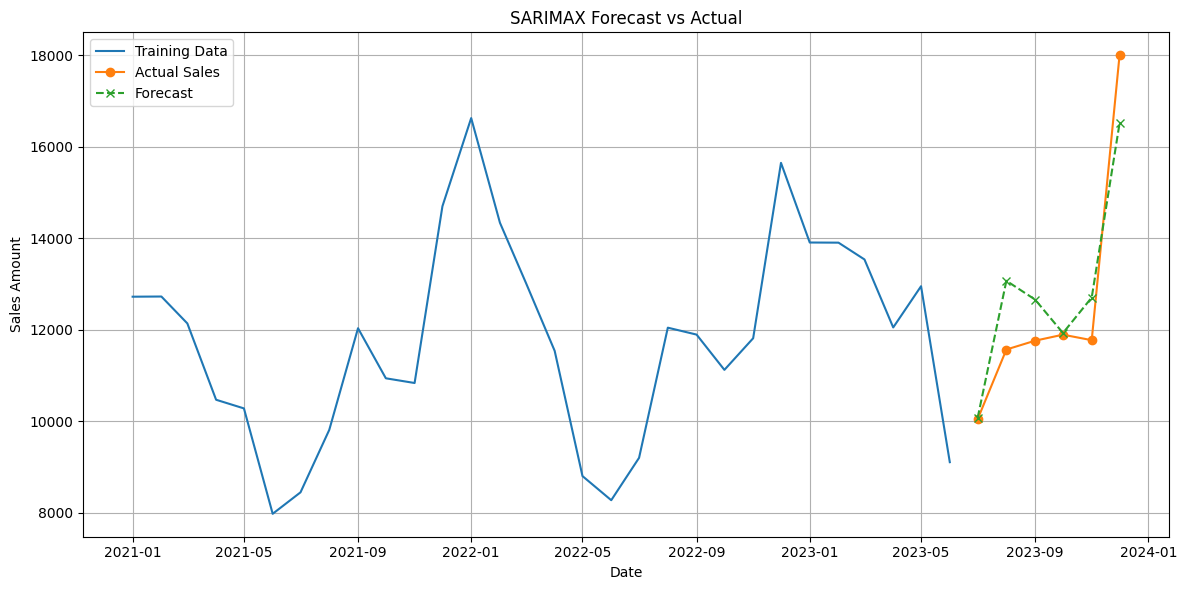

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['SalesAmount'], label='Training Data')
plt.plot(valid.index, valid['SalesAmount'], label='Actual Sales', marker='o')
plt.plot(valid.index, forecast, label='Forecast', linestyle='--', marker='x')
plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<H3>Save Forecast for Reporting</H3>

In [28]:
forecast_df = pd.DataFrame({
    'Date': valid.index,
    'Actual': valid['SalesAmount'],
    'Forecast': forecast
})
forecast_df.to_csv("validation_forecast_comparison.csv", index=False)

# Step 4: Model Evaluation and Forecasting

<H3>4.1: Retrain the Model on the Full Dataset</H3>

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Re-set index frequency just in case
df.index = pd.DatetimeIndex(df.index, freq='MS')

# Re-train on the entire dataset
full_model = SARIMAX(df['SalesAmount'],
                     order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 12),
                     exog=df[['Promotion', 'HolidayMonth']],
                     enforce_stationarity=True,
                     enforce_invertibility=True)

full_result = full_model.fit(disp=False)


c:\Users\zamin\anaconda3\envs\data-science\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<H3>4.2: Create Future Exogenous Variables (Next 6 Months)</H3>

In [30]:
import pandas as pd
import numpy as np

# Create date range for next 6 months
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=6, freq='MS')

# Generate future exogenous data
future_exog = pd.DataFrame(index=future_dates)
np.random.seed(42)
future_exog['Promotion'] = np.random.choice([0, 1], size=6, p=[0.8, 0.2])
future_exog['HolidayMonth'] = (future_exog.index.month == 12).astype(int)

<H3>4.3: Forecast the Next 6 Months</H3>

In [31]:
# Forecast
future_forecast = full_result.get_forecast(steps=6, exog=future_exog)
forecast_df = future_forecast.summary_frame()

# Rename for clarity
forecast_df = forecast_df.rename(columns={
    'mean': 'Forecast',
    'mean_ci_lower': 'Lower_CI',
    'mean_ci_upper': 'Upper_CI'
})
forecast_df['Date'] = future_dates
forecast_df = forecast_df[['Date', 'Forecast', 'Lower_CI', 'Upper_CI']]
forecast_df.set_index('Date', inplace=True)

# Show results
forecast_df

SalesAmount,Forecast,Lower_CI,Upper_CI
Date,,,
2024-01-01,15387.496681,13724.134101,17050.859260
2024-02-01,18653.217412,16716.606191,20589.828632
2024-03-01,14954.044529,12798.972276,17109.116782
2024-04-01,13467.557612,11115.501501,15819.613723
2024-05-01,11059.493192,8525.803564,13593.182819
2024-06-01,10513.577944,7810.437258,13216.718630


<H3>4.4: Plot Final Forecast with Confidence Intervals</H3>

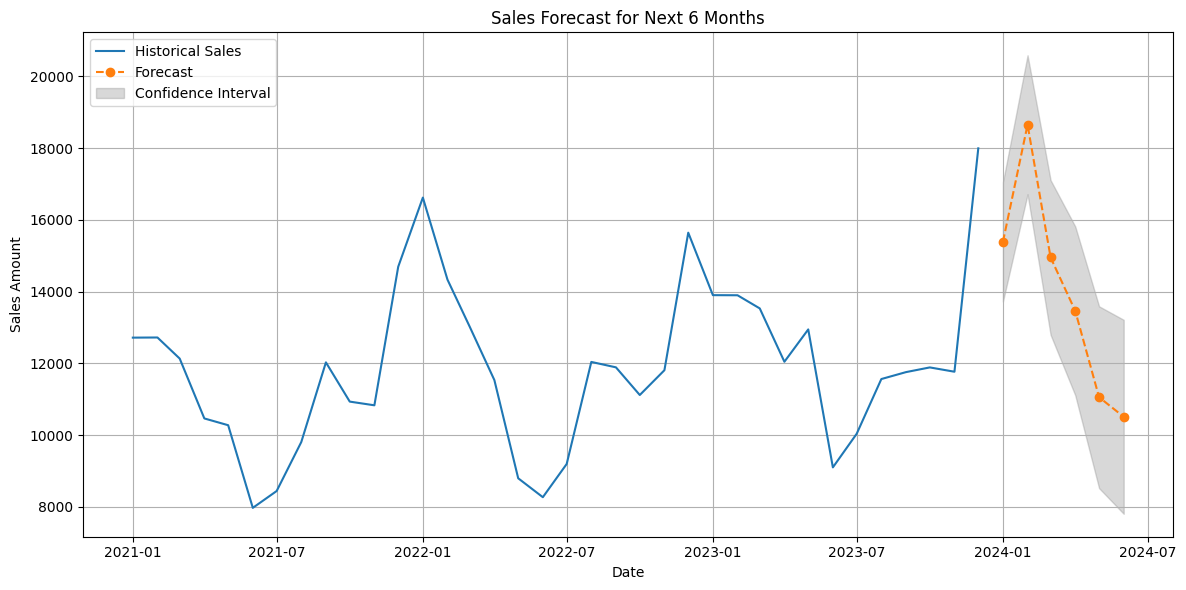

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df['SalesAmount'], label='Historical Sales')
plt.plot(forecast_df['Forecast'], label='Forecast', linestyle='--', marker='o')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], 
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.title('Sales Forecast for Next 6 Months')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<H3>Save to CSV (Deliverable)</H3>

In [33]:
forecast_df.to_csv('sales_forecast_next_6_months.csv')